In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import halfspace.load as hs
import halfspace.projections as hsp
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import json
from numba import jit
import gdal

In [3]:
stress_file = '../stress_arrays/wnfs_topo_stress.h5'

sdb = h5py.File(stress_file, 'r')

In [4]:
sdb['xx_MPa'].shape, np.product(sdb['xx_MPa'].shape)

((1397, 1674, 51), 119267478)

In [5]:
conv_shape = sdb['xx_MPa'].shape

In [6]:
with open('../../nepal_2015/stress_arrays/stress_calcs_meta.json') as f:
    s_meta = json.load(f)

In [7]:
s_meta

{'b_conv_mode': 'valid', 'c_conv_mode': 'same', 'z_max': 30000, 'z_res': 500}

In [8]:
z_len = sdb['xx_MPa'].shape[2]

z_vec = np.linspace(s_meta['z_res'], s_meta['z_max'], z_len)

In [9]:
with open('../data/dem/wnfs_dem_utm45_meta.json', 'r') as f:
    d_meta = json.load(f)

In [10]:
d_meta

{'east_max': 868665.9344798587,
 'east_min': -368334.0655201413,
 'lat_max': 34.05579460696701,
 'lat_min': 23.96819102557579,
 'lon_max': 90.99354408576976,
 'lon_min': 78.4860095977793,
 'n_cols': 2474,
 'n_rows': 2197,
 'north_max': 3775544.3200867064,
 'north_min': 2677044.3200867064,
 'upper_left_x': -368334.0655201413,
 'upper_left_y': 3775544.3200867064,
 'x_res_m': 500.0,
 'x_rotation': 0.0,
 'y_res_m': 500.0,
 'y_rotation': 0.0}

In [11]:
conv_shape

(1397, 1674, 51)

In [12]:
dem_e = np.linspace(d_meta['east_min'], d_meta['east_max'], d_meta['n_cols'])
dem_n = np.linspace(d_meta['north_min'], d_meta['north_max'], d_meta['n_rows'])

convo_e = hs._centered(dem_e, conv_shape[1])
convo_n = hs._centered(dem_n, conv_shape[0])

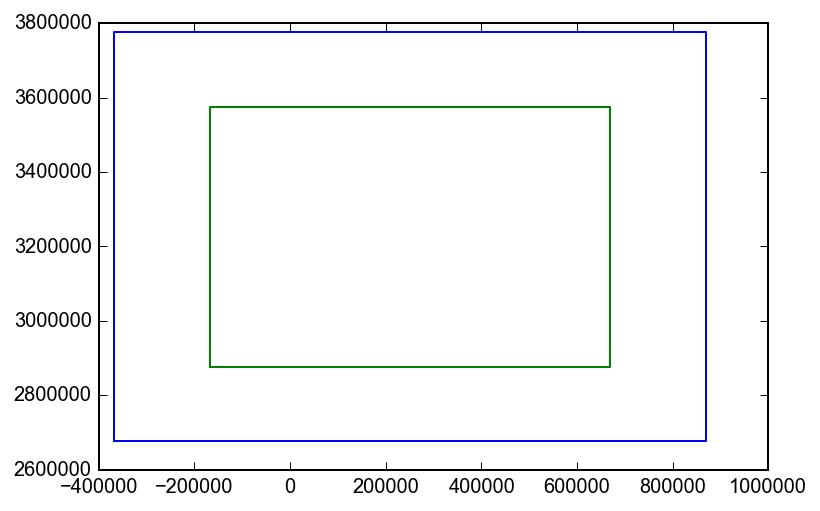

In [13]:
plt.plot( (dem_e.min(), dem_e.max(), dem_e.max(), dem_e.min(), dem_e.min()),
          (dem_n.min(), dem_n.min(), dem_n.max(), dem_n.max(), dem_n.min()))

plt.plot( (convo_e.min(), convo_e.max(), convo_e.max(), convo_e.min(), convo_e.min()),
          (convo_n.min(), convo_n.min(), convo_n.max(), convo_n.max(), convo_n.min()))

In [14]:
z_vec

array([   500.,   1090.,   1680.,   2270.,   2860.,   3450.,   4040.,
         4630.,   5220.,   5810.,   6400.,   6990.,   7580.,   8170.,
         8760.,   9350.,   9940.,  10530.,  11120.,  11710.,  12300.,
        12890.,  13480.,  14070.,  14660.,  15250.,  15840.,  16430.,
        17020.,  17610.,  18200.,  18790.,  19380.,  19970.,  20560.,
        21150.,  21740.,  22330.,  22920.,  23510.,  24100.,  24690.,
        25280.,  25870.,  26460.,  27050.,  27640.,  28230.,  28820.,
        29410.,  30000.])

In [15]:
depth_ind = 12
depth = z_vec[depth_ind]
depth

7580.0

In [16]:
xx_stress = sdb['xx_MPa'][:,:,depth_ind]
yy_stress = sdb['yy_MPa'][:,:,depth_ind]
zz_stress = sdb['zz_MPa'][:,:,depth_ind]
xy_stress = sdb['xy_MPa'][:,:,depth_ind]
xz_stress = sdb['xz_MPa'][:,:,depth_ind]
yz_stress = sdb['yz_MPa'][:,:,depth_ind]

In [46]:
T.abs()

0
txx    0.118852
txy    0.033519
tyy    0.229527
Name: 1, dtype: float64

In [17]:
T = pd.read_csv('../results/T_best.csv', index_col=0, header=None, squeeze=True)
T

0
txx   -0.118852
txy    0.033519
tyy    0.229527
Name: 1, dtype: float64

In [18]:
def cart_stresses_to_eigs(xx=0., yy=0., xy=0.):
    
    T = hsp.make_xy_stress_tensor(xx, yy, xy)
    
    vals, vecs = hsp.sorted_eigens(T)
    
    s1, s3 = vals[1], vals[0]
    
    max_x = vecs[0,1] * s1
    max_y = vecs[1,1] * s1
    
    theta = hsp.angle_to_azimuth( np.arctan2(max_y, max_x))
    
    return s1, s3, theta

In [42]:
rg = 9.81 * 2700 / 1e6

rgz = rg *depth #* 0
#txx, tyy, txy = T.txx * rgz, T.tyy * rgz, T.txy * rgz

txx, tyy, txy = 0.033 * rgz, 0.467 * rgz, 0.125 * rgz # experimental

stress_scale = 0.4


txx *= stress_scale
tyy *= stress_scale
txy *= stress_scale


txx, tyy, txy

(2.650183272, 37.504108727999999, 10.038573)

In [44]:
list(cart_stresses_to_eigs(txx, tyy, txy) / rgz)

[0.20017105370315322, -0.00017105370315318745, 0.074571178026528337]

In [34]:
txx, tyy, txy = (T.txx * rgz, T.tyy * rgz, T.txy * rgz)

txx, tyy, txy

(-23.862014743555452, 46.082537014654719, 6.7297075088526439)

In [21]:
rgz

200.77145999999999

In [20]:
nrows, ncols = xx_stress.shape

In [21]:
sd = {'xx': xx_stress + txx,
      'yy': yy_stress + tyy,
      'zz': zz_stress,
      'xy': xy_stress + txy,
      'xz': xz_stress,
      'yz': yz_stress}

In [22]:
#@jit
def deform_style(T, P):
    
    return P.plunge - T.plunge
    
    
#@jit
def deform_style_from_tensor(S):
    T, N, P = hsp.get_princ_axes_xyz(S)
    
    return deform_style(T, P)


def diff_stress_from_tensor(S):
    vals, vecs = hsp.sorted_eigens(S)
    return np.abs(vals[0] - vals[2])


def max_coulomb_stress(S, pressure):
    opt_strike, opt_dip = hsp.find_optimal_plane(S,
                               friction_coefficient=0.6)
    return hsp.coulomb_shear_stress_from_xyz(opt_strike,
                                             opt_dip, S,
                                             pressure=pressure)

#@jit
def make_S(sd, i, j):
    
    return hsp.make_xyz_stress_tensor(sig_xx=sd['xx'][i,j],
                                      sig_yy=sd['yy'][i,j],
                                      sig_zz=sd['zz'][i,j],
                                      sig_xy=sd['xy'][i,j],
                                      sig_xz=sd['xz'][i,j],
                                      sig_yz=sd['yz'][i,j])

#@jit
def def_style_from_ij(sd, i,j):
    
    S = make_S(sd, i, j)
    
    return deform_style_from_tensor(S)


def diff_stress_from_ij(sd, i, j):
    S = make_S(sd, i, j)
    
    return diff_stress_from_tensor(S)


@jit
def def_styles_array(sd, nskip):
    nrows = sd['xx'].shape[0] 
    ncols = sd['xx'].shape[1]
    
    
    def_styles = np.zeros( (len(range(nrows)[::nskip]), 
                            len(range(ncols)[::nskip])) )

    for i, ii in enumerate(range(nrows)[::nskip]):
        for j, jj in enumerate(range(ncols)[::nskip]):
            def_style = def_style_from_ij(sd, ii, jj)
            def_styles[i,j] = def_style
            
    return def_styles

@jit
def diff_stress_array(sd, nskip):
    nrows = sd['xx'].shape[0] 
    ncols = sd['xx'].shape[1]
    
    
    diff_stress = np.zeros( (len(range(nrows)[::nskip]), 
                             len(range(ncols)[::nskip])) )

    for i, ii in enumerate(range(nrows)[::nskip]):
        for j, jj in enumerate(range(ncols)[::nskip]):
            diff_str = diff_stress_from_ij(sd, ii, jj)
            diff_stress[i,j] = diff_str
            
    return diff_stress
    
    
def opt_coulomb_stress_array(sd, nskip, pressure):
    nrows = sd['xx'].shape[0] 
    ncols = sd['xx'].shape[1]
    
    
    coul_stress = np.zeros( (len(range(nrows)[::nskip]), 
                             len(range(ncols)[::nskip])) )

    for i, ii in enumerate(range(nrows)[::nskip]):
        for j, jj in enumerate(range(ncols)[::nskip]):
            S = make_S(sd, ii, jj)
            coul_stress[i,j] = max_coulomb_stress(S, pressure)
            
    return coul_stress
    

In [23]:
S_test = hsp.make_xyz_stress_tensor(sig_xx=100, sig_yy=35, sig_zz = 20)

%timeit deform_style_from_tensor(S_test)

The slowest run took 80.06 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 78.9 µs per loop


In [45]:
#%%timeit
n_skip = 10

def_styles = np.array([def_style_from_ij(sd, i, j) for i in range(nrows)[::n_skip] 
                                                   for j in range(ncols)[::n_skip]])
def_styles = def_styles.reshape((len(range(nrows)[::n_skip]), 
                                 len(range(ncols)[::n_skip])))

In [27]:
%%timeit #def_styles = 
def_styles_array(sd, n_skip)

1 loops, best of 3: 2.38 s per loop


In [26]:
diff_stress = diff_stress_array(sd, n_skip)

In [27]:
opt_c = opt_coulomb_stress_array(sd, n_skip, 0.)

In [28]:
def_styles.shape

(140, 168)

In [31]:
def array_to_raster(array):
    
    arr32 = np.flipud( array.astype('float32') )
    
    dst_filename = '../results/example_deform_style.tif'
    
    driver = gdal.GetDriverByName('GTiff')
    
    dataset = driver.Create(
        dst_filename,
        ncols,
        nrows,
        1,
        gdal.GDT_Float32, )
    
    dataset.SetGeoTransform((convo_e.min(),
                            500.,
                            0,
                            convo_n.max(),
                            0,
                            -500.))
    dataset.SetProjection('EPSG:32645')
    dataset.GetRasterBand(1).WriteArray(arr32)
    dataset.FlushCache()

In [118]:
#array_to_raster(def_styles)

In [113]:
ncols, nrows

(1674, 1397)

In [114]:
len(convo_e), len(convo_n)

(1397, 1674)

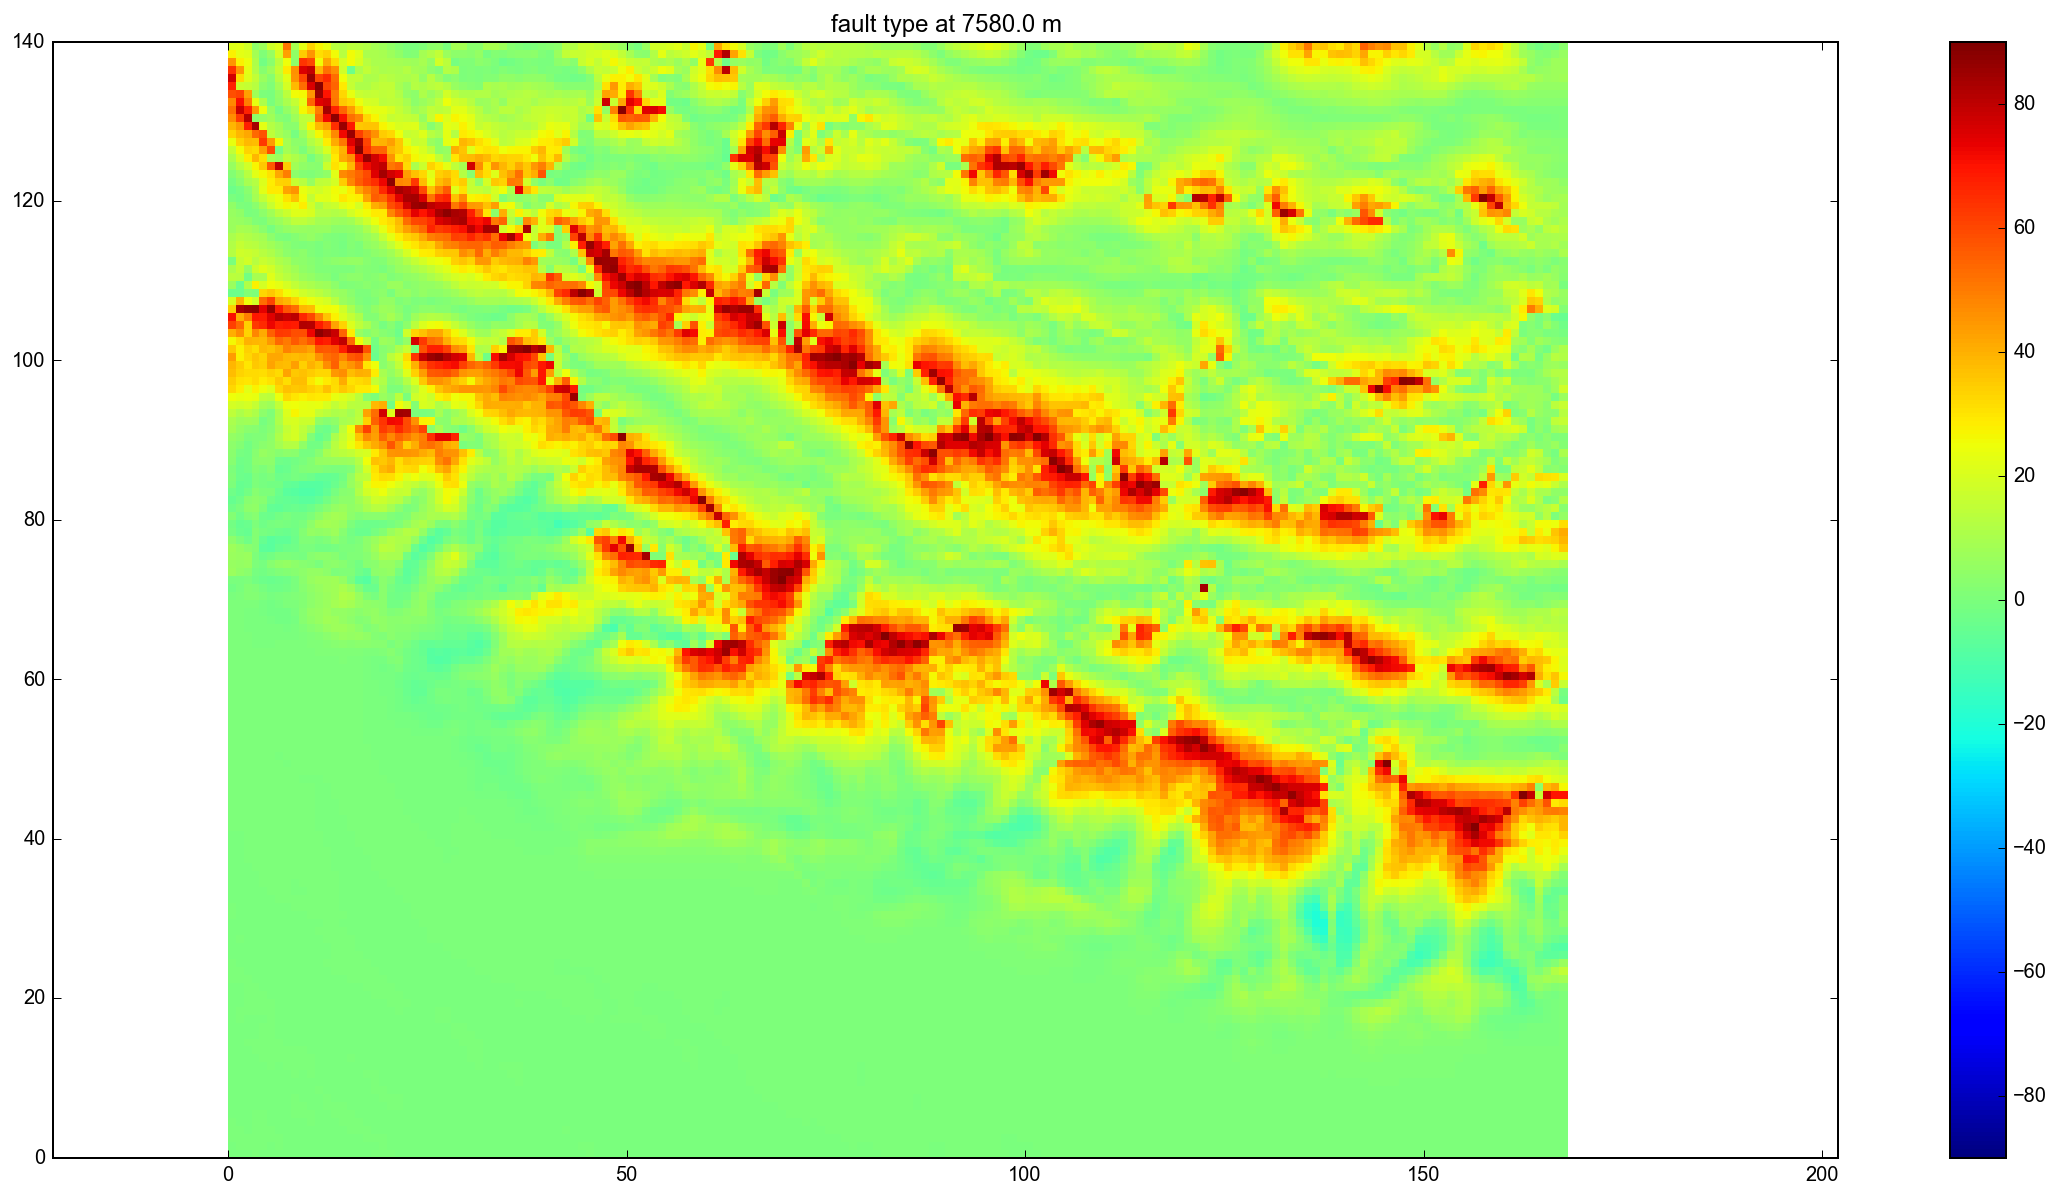

In [29]:
plt.figure(figsize=(20,10))

p = plt.pcolormesh(def_styles, vmax=90, vmin=-90)
plt.colorbar()
#plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))

plt.show()

/Users/itchy/src/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


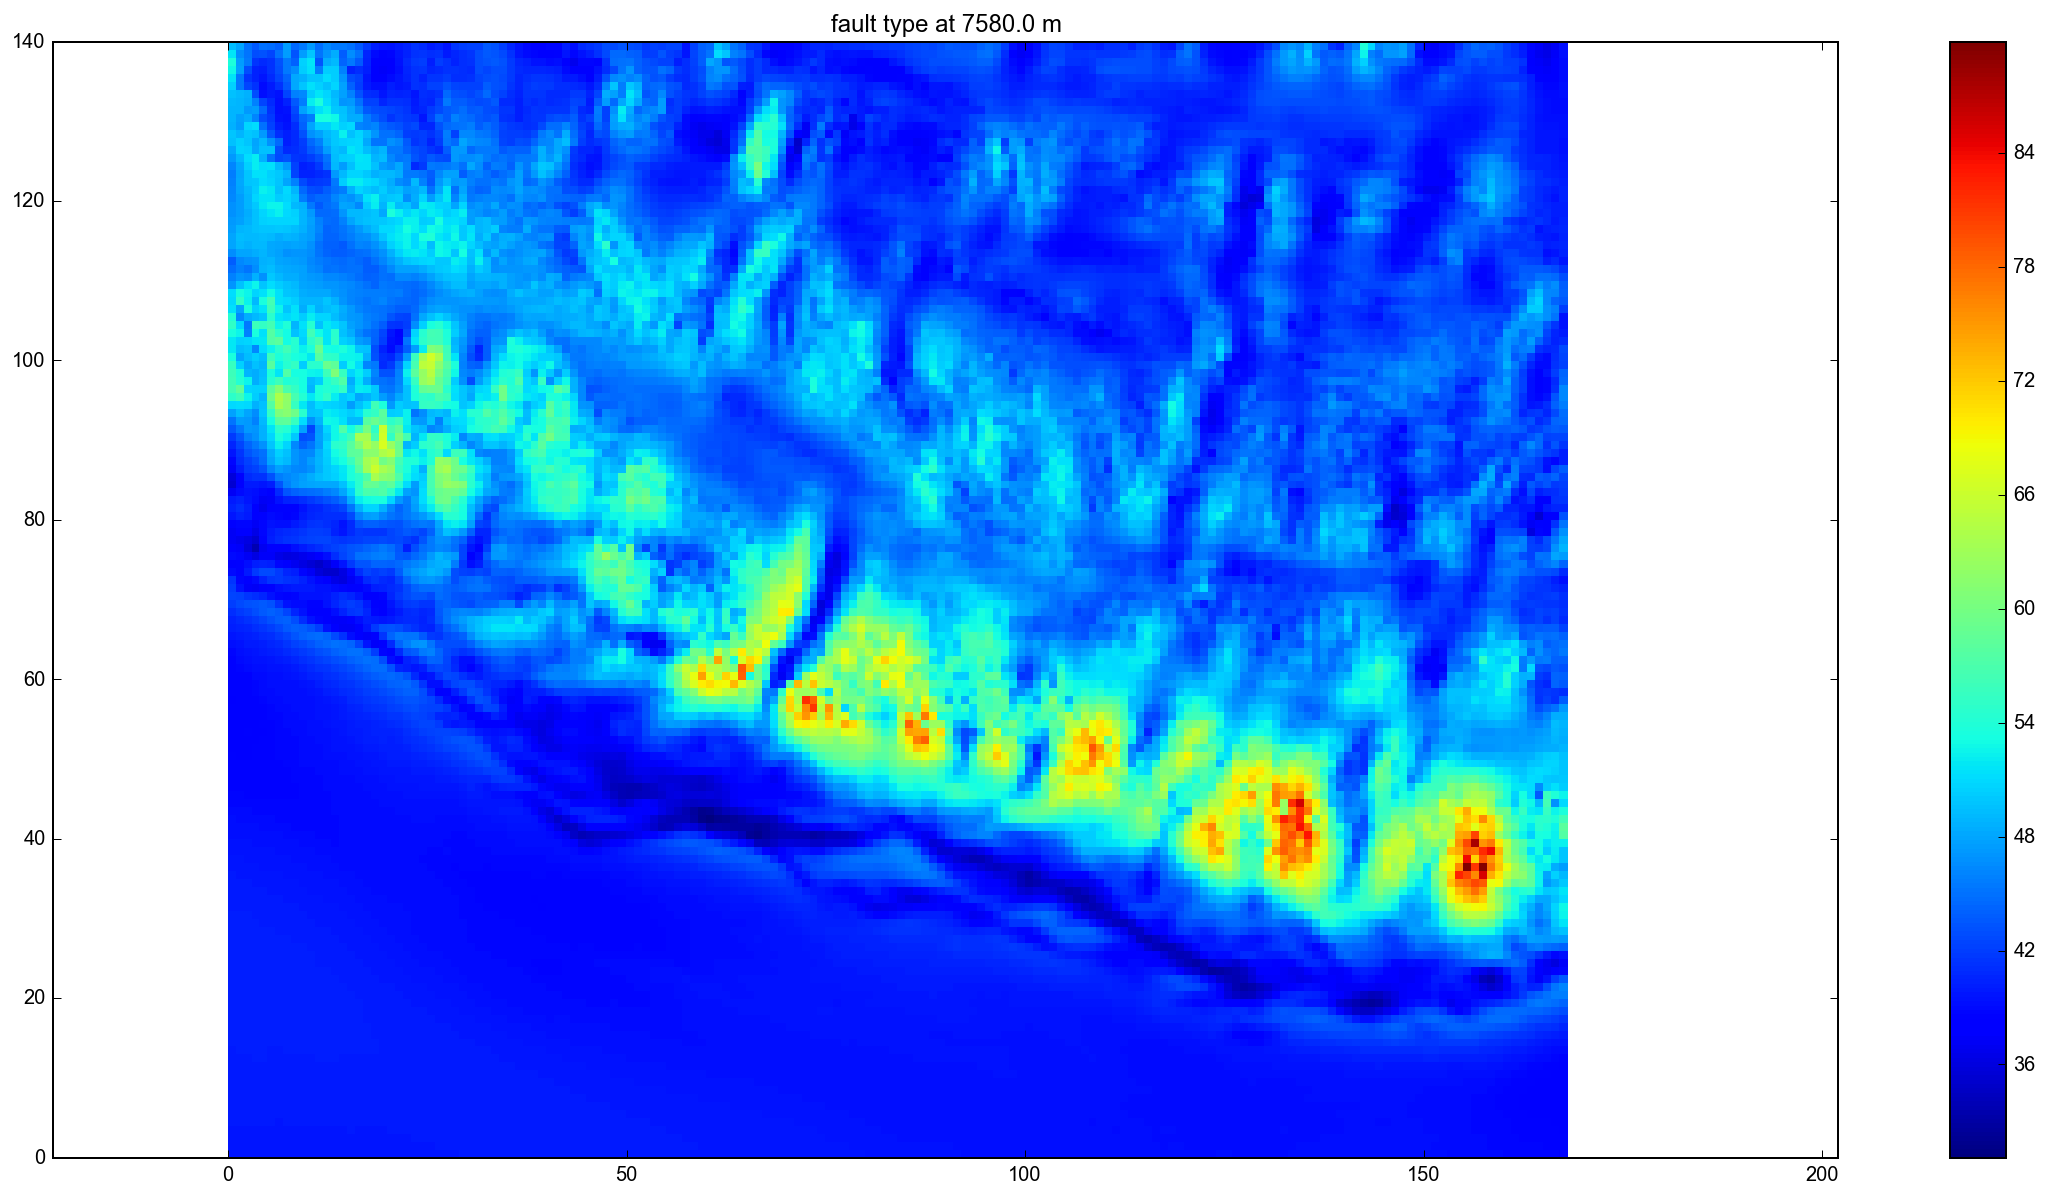

In [37]:
plt.figure(figsize=(20,10))

p = plt.pcolormesh(diff_stress)#, vmax=90, vmin=-90)
plt.colorbar()
#plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))

plt.show()

/Users/itchy/src/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


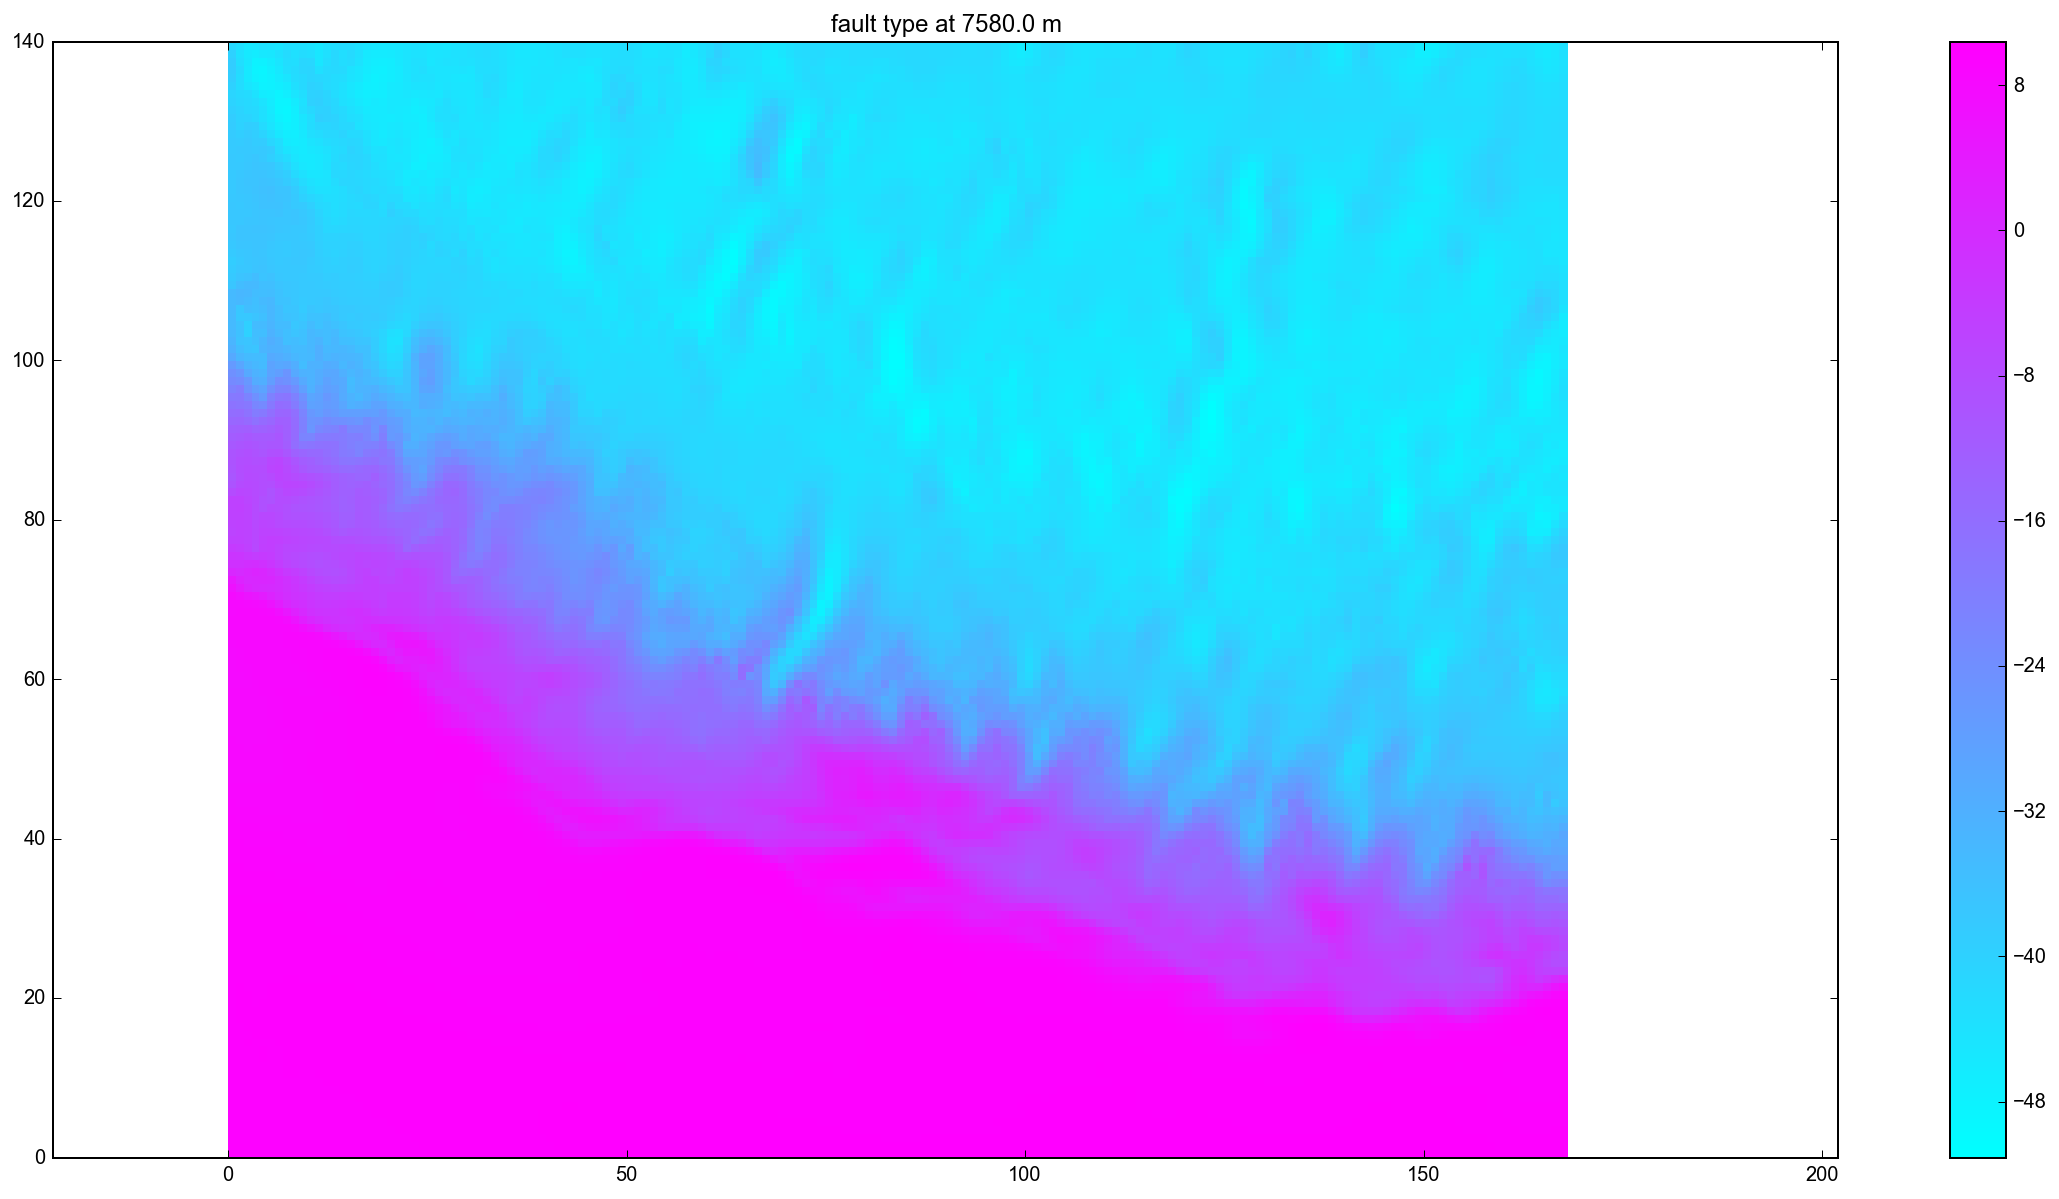

In [38]:
plt.figure(figsize=(20,10))

p = plt.pcolormesh(opt_c, cmap='cool')#, vmax=90, vmin=-90)
plt.colorbar()
#plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))

plt.show()

In [44]:
dem_dataset = gdal.Open('../data/dem/wnfs_dem_utm45_500m.tif')

dem = dem_dataset.GetRasterBand(1).ReadAsArray()

dem = np.flipud(dem)

dem = hs._centered(dem, conv_shape[:2])

/Users/itchy/src/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


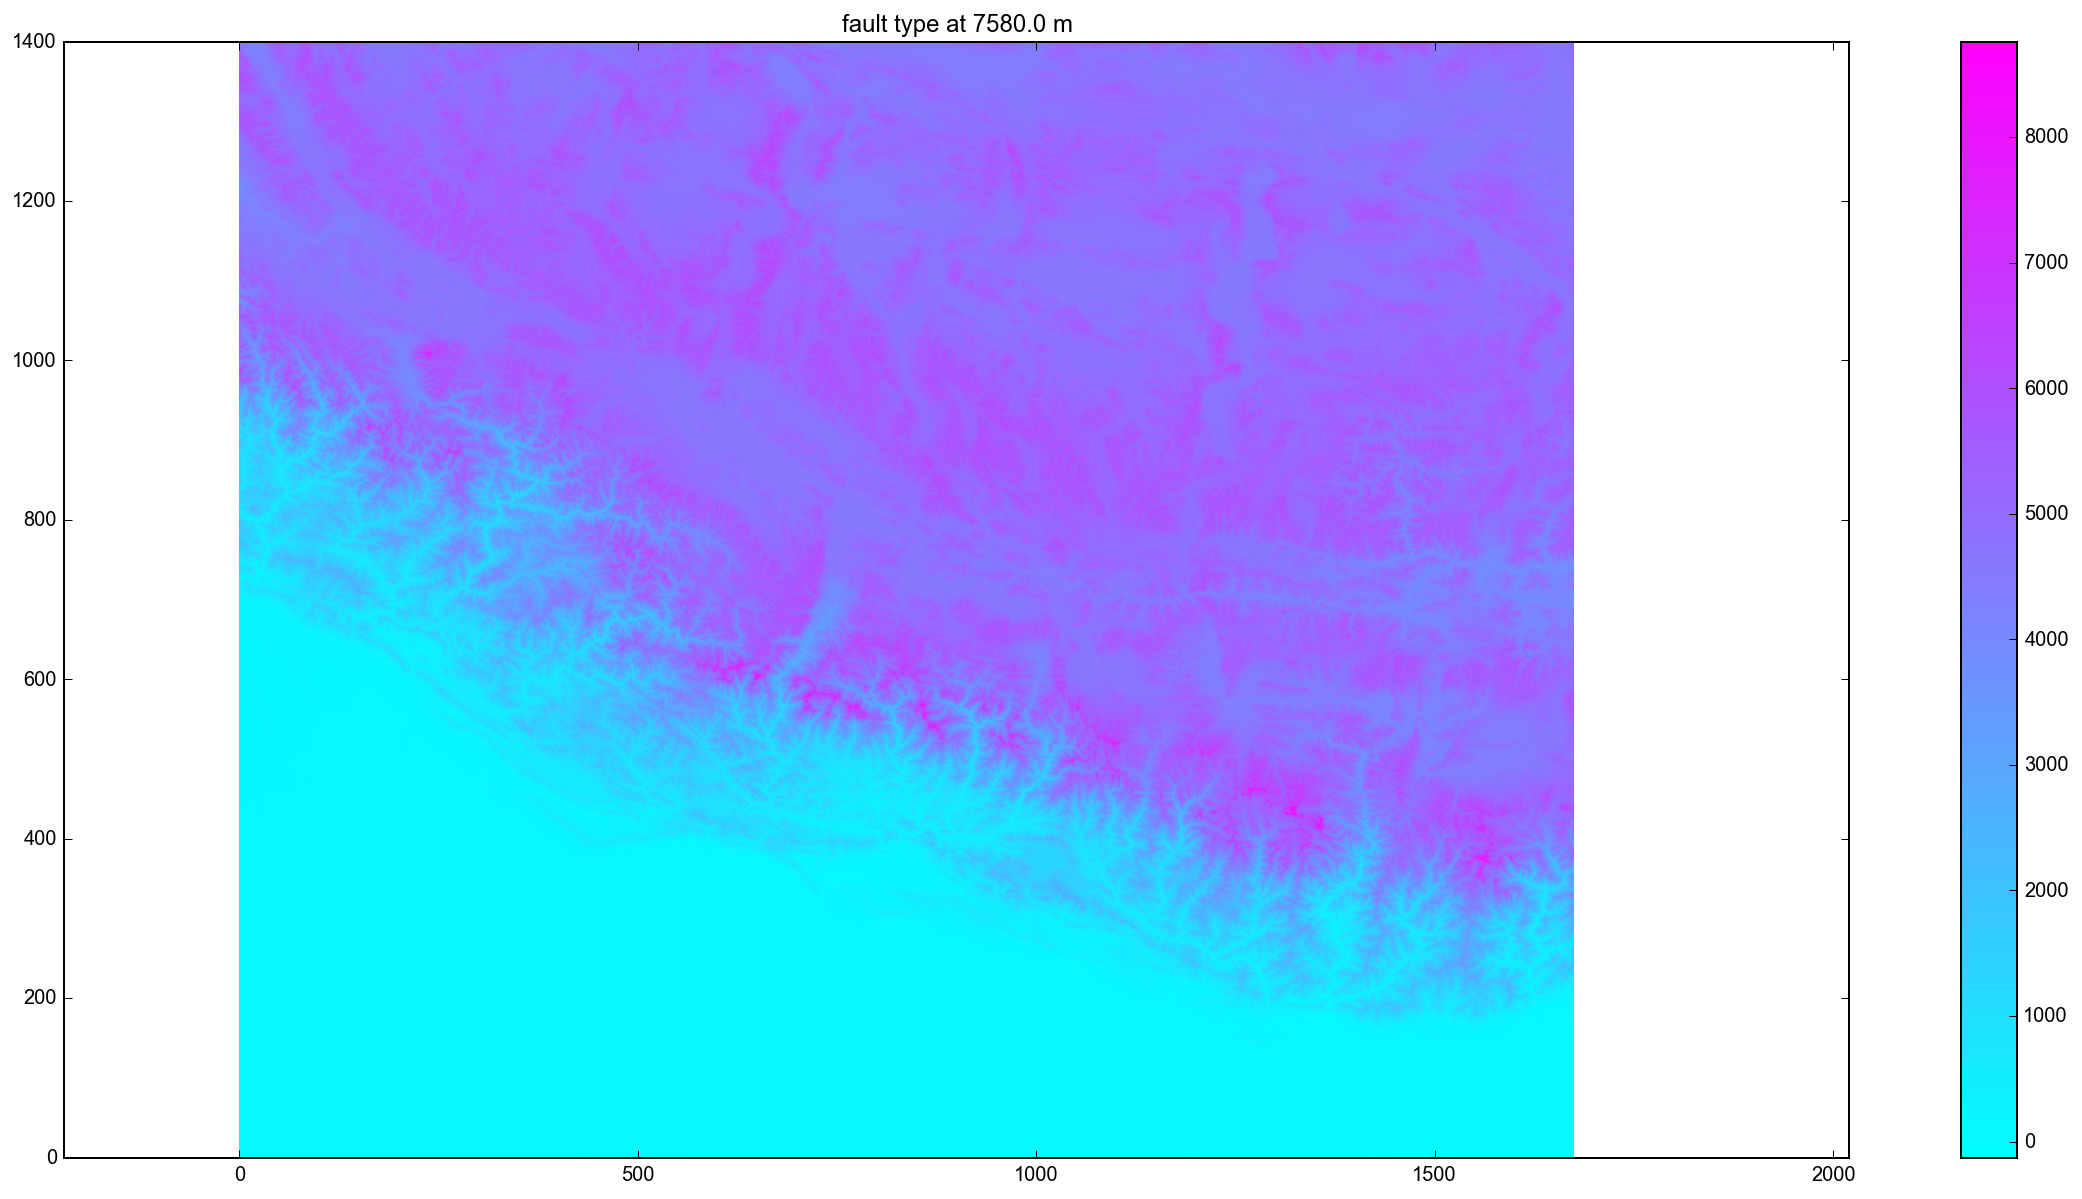

In [45]:
plt.figure(figsize=(20,10))

p = plt.pcolormesh(dem, cmap='cool')#, vmax=90, vmin=-90)
plt.colorbar()
#plt.contour(def_styles, [30, -30], colors='k', lw=0.25)
plt.axis('equal')
plt.title('fault type at {} m'.format(depth))

plt.show()

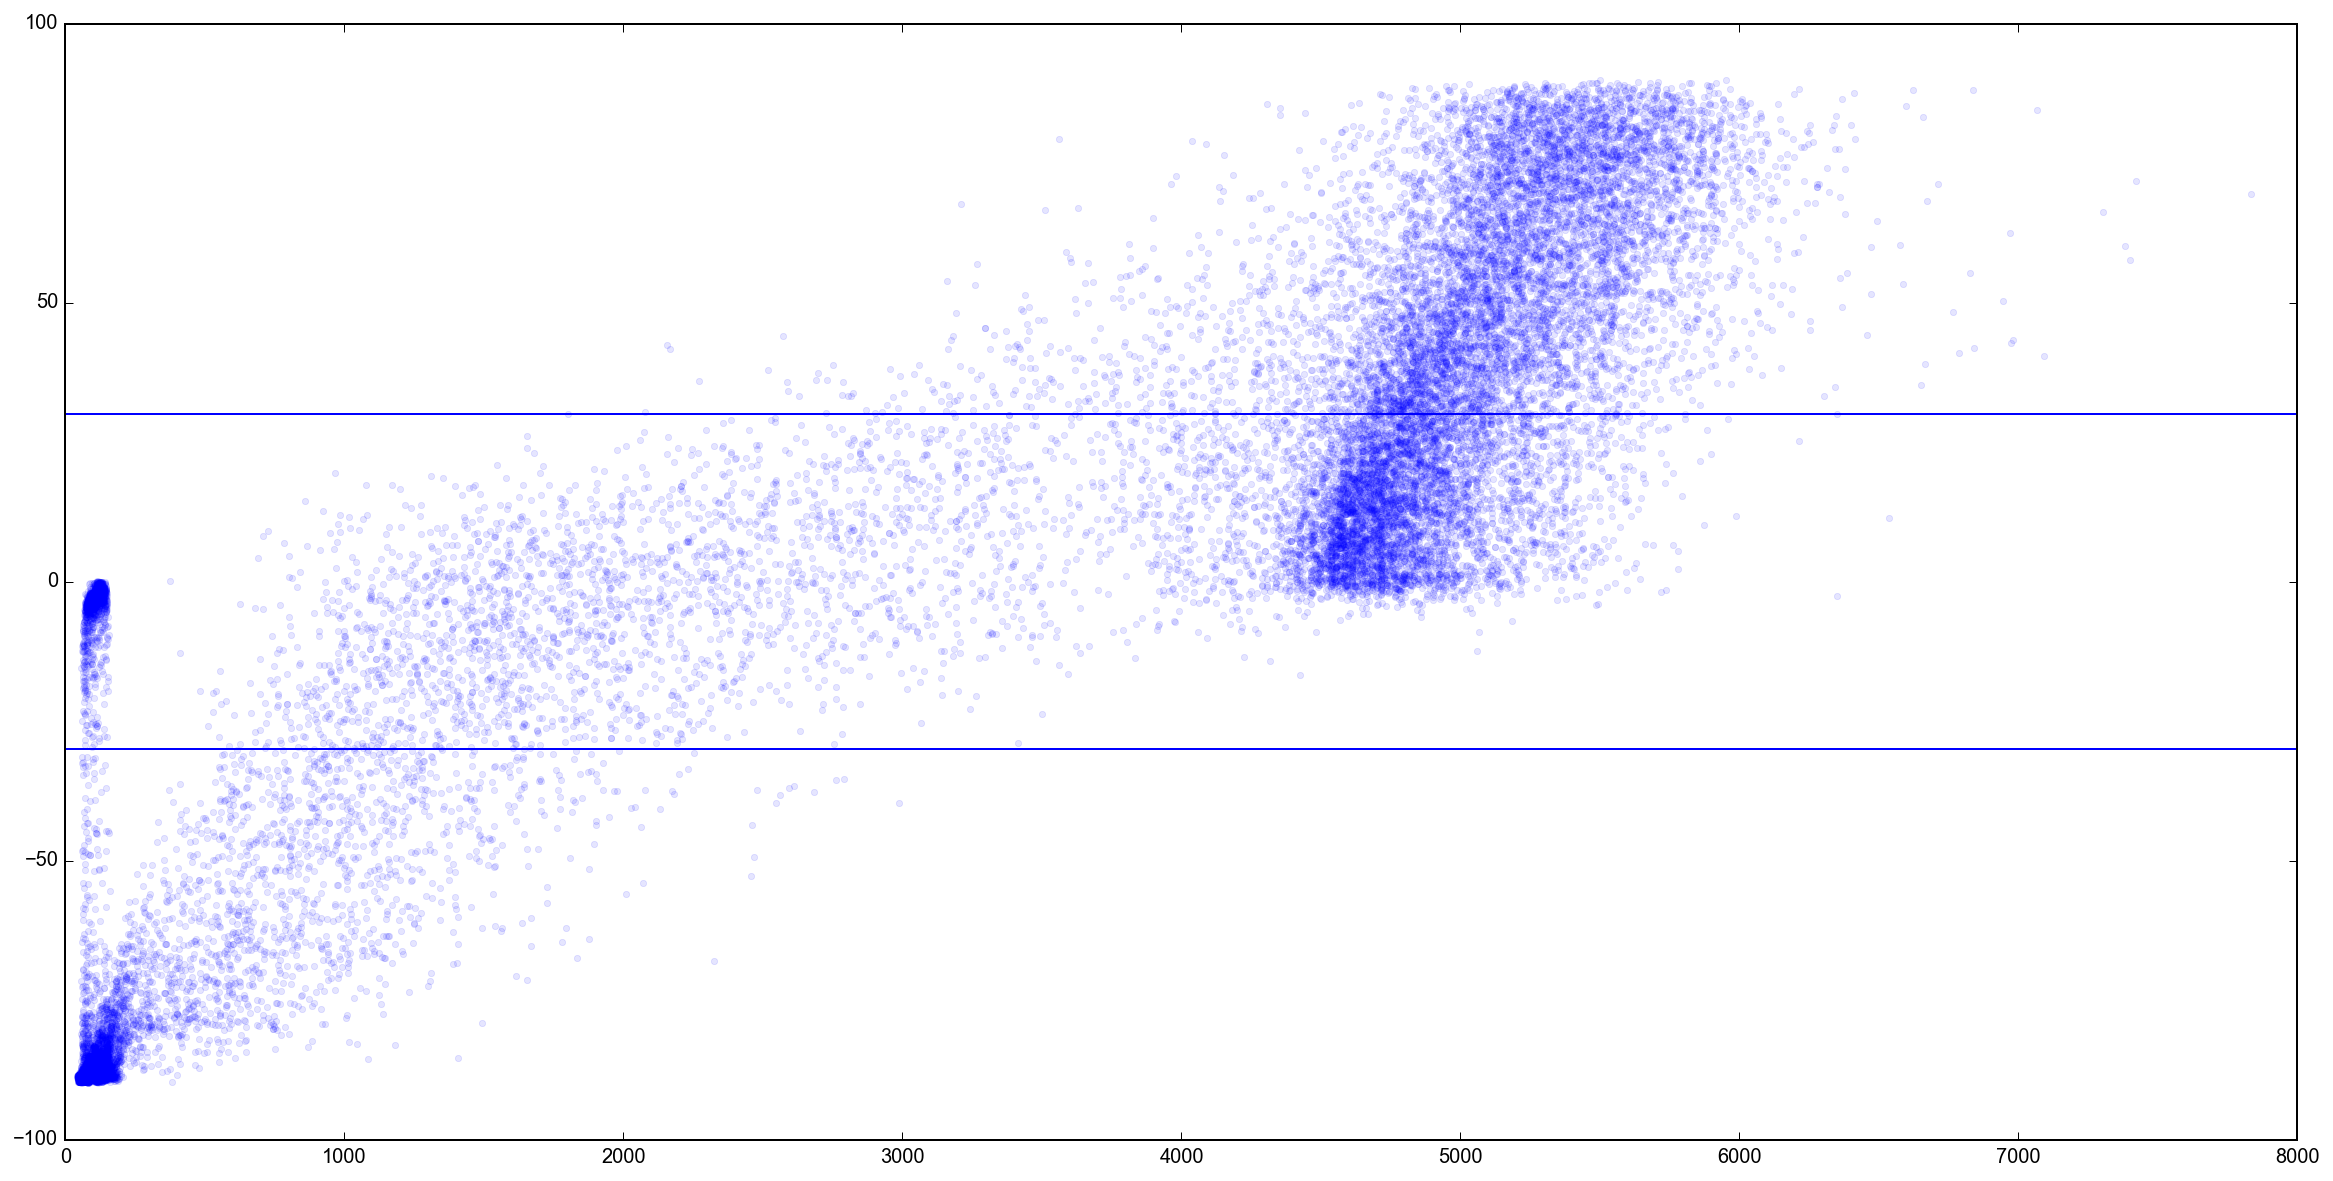

In [49]:
plt.figure(figsize=(20,10))

plt.axhline(30)
plt.axhline(-30)
plt.plot(dem[::n_skip, ::n_skip].ravel(), def_styles.ravel(), '.', alpha=0.1)
plt.show()